# Part 1

## Implement Neural Network from scratch

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from math import sqrt
from numpy.random import rand
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, Flatten
from tensorflow.keras.preprocessing.text import one_hot
from keras.layers import Dropout
from sklearn.metrics import accuracy_score

## Read in dataset

In [2]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Machine Learning Projects/HW3/dataset.csv")
df_small = df.sample(n=1000, random_state=42)
data = np.array(df_small)

## Neural Network Class

In [3]:
class neural_network:
    def __init__(self, layer_sizes, learning_rate=0.01):
      self.layer_sizes = layer_sizes
      self.learning_rate = learning_rate
      # holds the weights bewteen the layers
      self.weights = []
      # holds the biases for each layer
      self.biases = []
      # holds the activations for forward pass
      self.activations = []

      # initialize weights and biases using Xavier/Glorot-like initialization
      for i in range(len(layer_sizes)-1):
        current_layer_size = layer_sizes[i]
        next_layer_size = layer_sizes[i + 1]

        # set initialization bounds
        lower = -(1.0 / np.sqrt(current_layer_size))
        upper = (1.0 / np.sqrt(current_layer_size))

        # generate random weights in the specified range
        random_numbers = np.random.rand(current_layer_size, next_layer_size)
        weight = lower + random_numbers * (upper - lower)

        # bias initialized to zeros
        bias = np.zeros((1, next_layer_size))

        self.weights.append(weight)
        self.biases.append(bias)

    def forward_propagation(self, X):
      # perform forward pass through the network
      # first activation is inpu
      self.activations = [X]
      # list to store linear combinations (Z) at each layer
      self.Zs = []
      activation = X

      for i in range(len(self.weights)):
        Z = np.dot(activation, self.weights[i]) + self.biases[i]
        self.Zs.append(Z)
        # sigmoid activation for all layers
        activation = self.sigmoid(Z)
        self.activations.append(activation)

      return activation

    def backpropagation(self, X, y):
      m = X.shape[0]
      y = y.reshape(-1, 1)

      output = self.forward_propagation(X)

      # initialize gradients for weights and biases
      dW = [0] * len(self.weights)
      dB = [0] * len(self.biases)

      # derivative of loss w.r.t. activation (mean squared error)
      dA = (output - y)

      # loop backward through layers
      for i in reversed(range(len(self.weights))):
        dZ = dA * self.sigmoid_derivative(self.Zs[i])
        dW[i] = np.dot(self.activations[i].T, dZ) / m
        dB[i] = np.sum(dZ, axis=0, keepdims=True) / m

        if i > 0:
          dA = np.dot(dZ, self.weights[i].T)

      # update weights and biases
      for i in range(len(self.weights)):
        self.weights[i] -= self.learning_rate * dW[i]
        self.biases[i] -= self.learning_rate * dB[i]

    def train(self, X, y, epochs):
      # train the model using full-batch gradient descent
      for epoch in range(epochs):
        self.backpropagation(X, y)
        if epoch % 100 == 0 or epoch == epochs - 1:
          loss = self.cost(X, y)
          print(f"Epoch {epoch}, Loss: {loss:.4f}")

    def cost(self, X, y):
      # compute mean squared error loss
      m = X.shape[0]
      y_hat = self.forward_propagation(X)
      return np.mean((y_hat - y.reshape(-1, 1)) ** 2)

    def predict(self, X):
      # generate predictions (0 or 1)
      output = self.forward_propagation(X)
      return (output > 0.5).astype(int)

    def sigmoid(self, z):
      # sigmoid activation function
      return 1 / (1 + np.exp(-z))

    def sigmoid_derivative(self, z):
      # derivative of sigmoid (used in backprop)
      sig = self.sigmoid(z)
      return sig * (1 - sig)

    # other gradient descent methods

    def train_sgd(self, X, y, epochs):
      m = X.shape[0]
      # loop through each specified number of epochs
      for epoch in range(epochs):
        # iterate through each training sample
        for i in range(m):
          x_i = X[i].reshape(1, -1)
          y_i = np.array([y[i]])
          # backpropagation using a single example
          self.backpropagation(x_i, y_i)
        if epoch % 100 == 0 or epoch == epochs - 1:
          loss = self.cost(X, y)
          print(f"[SGD] Epoch {epoch}, Loss: {loss:.4f}")

    def train_minibatch(self, X, y, epochs, batch_size=32):
      m = X.shape[0]
      for epoch in range(epochs):
        # Shuffle the data
        indices = np.arange(m)
        np.random.shuffle(indices)
        X = X[indices]
        y = y[indices]

        for i in range(0, m, batch_size):
          # current mini batch
          X_batch = X[i:i + batch_size]
          y_batch = y[i:i + batch_size]
          self.backpropagation(X_batch, y_batch)
        if epoch % 100 == 0 or epoch == epochs - 1:
          loss = self.cost(X, y)
          print(f"[MiniBatch] Epoch {epoch}, Loss: {loss:.4f}")

Binary encoding so our model can understand the values

In [4]:
df_small.head()
df_small.humor.value_counts()

# one hot encoding, converting "True" and "False" to 1 and 0 respectively
df_small['is_funny'] = df_small['humor'].apply(lambda x: 0 if x == False else 1)

In [5]:
df_small = df_small.drop(['humor'], axis=1)
df_small.head()

,text,is_funny
119737,When is the best time to play racquet sports? ...,1
72272,City apartments vs. suburban living: which one...,0
158154,San francisco approves health warnings on ads ...,0
65426,"How white privilege, white supremacy and insti...",0
30074,The oil lobby has a pretty predictable respons...,0


In [6]:
X_train, X_test, y_train, y_test = train_test_split(df_small.text, df_small.is_funny, test_size=0.2)

In [7]:
# implementing bag of words technique, so that the model can accurately understand the sentences inputted
v = CountVectorizer()
X_train_cv = v.fit_transform(X_train.values)
X_test_cv = v.transform(X_test)
X_train_cv

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 8838 stored elements and shape (800, 3375)>

In [8]:
X_train_cv.toarray()[0]

array([0, 0, 0, ..., 0, 0, 0])

In [9]:
X_train_cv.shape

(800, 3375)

In [10]:
v.get_feature_names_out()[1000:1050]

array(['emo', 'empire', 'employee', 'empowerment', 'empty', 'end',
       'ending', 'endor', 'endorses', 'engagement', 'engineer', 'england',
       'enjoying', 'enough', 'entertaining', 'entirely',
       'entrepreneurism', 'environmentalists', 'epic', 'equality',
       'erection', 'erica', 'erika', 'errors', 'escalator', 'escape',
       'eskimo', 'especially', 'espn', 'estefan', 'etiquette',
       'europeans', 'evangelical', 'eve', 'even', 'event', 'events',
       'eventually', 'ever', 'everest', 'every', 'everyone', 'everything',
       'ewoks', 'ex', 'except', 'exciting', 'excluded', 'execution',
       'executioner'], dtype=object)

In [11]:
# I ended up using the Mini Batch technique because it had the highest
# accuracy, while also having a low training time


# input_size = X_train_cv.shape[1]
# nn = neural_network([input_size, 100, 1], learning_rate=0.1)

# input_size = X_train_cv.shape[1]
# nn2 = neural_network([input_size, 100, 1], learning_rate=0.1)

input_size = X_train_cv.shape[1]
nn3 = neural_network([input_size, 100, 1], learning_rate=0.1)

y_true = y_test.values

# print("Regular Gradient Descent:\n")
# print(nn.train(X_train_cv.toarray(), y_train.values, epochs=300))

# print("Stochastic Gradient Descent:\n")
# print(nn2.train_sgd(X_train_cv.toarray(), y_train.values, epochs=300))

print("Mini Batch Gradient Descent:\n")
print(nn3.train_minibatch(X_train_cv.toarray(), y_train.values, epochs=300))

# prediction
# print("Regular Gradient Descent:\n")
# prediction = nn.predict(X_test_cv.toarray())
# # Accuracy
# acc = accuracy_score(y_true, prediction)
# print(f"Accuracy: {acc:.4f}")

# prediction stochastic gradient descent
# print("SGD:\n")
# prediction = nn2.predict(X_test_cv.toarray())
# print("Prediction:", prediction)

# prediction mini batch gradient descent
print("Mini Batch:\n")
prediction = nn3.predict(X_test_cv.toarray())
# Accuracy
acc = accuracy_score(y_true, prediction)
print(f"Accuracy: {acc:.4f}")


Mini Batch Gradient Descent:

[MiniBatch] Epoch 0, Loss: 0.2506
[MiniBatch] Epoch 100, Loss: 0.1765
[MiniBatch] Epoch 200, Loss: 0.0919
[MiniBatch] Epoch 299, Loss: 0.0543
None
Mini Batch:

Accuracy: 0.8200


# Part 2
Implement a 2-layer neural network using any Deep Learning Framework

## Explaining why I used certain libraries

*   Sequential
  *   https://keras.io/guides/sequential_model/
  *   Keras' Sequential makes it easy to build a feedforward Neural Network. This makes it easy to define various parameters such as activation functions, and number of layers.

*   Layers
  *   https://keras.io/api/layers/
  *   Embeddings layer was used to convert word indices into dense vector representations
  *   Flatten layer was used to reshape the embeddings into a flat layer for dense layers
  *   Dense layer is used for the hidden and output layers for the neural network.
  *   Dropout is used for regularization, in order to prevent overfitting

*   Preprocessing
  *   https://www.tensorflow.org/api_docs/python/tf/keras/utils/pad_sequences
  *   https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/one_hot
  *   one_hot is used for converting sentences into sequences of integers
  *   pad_sequences makes sure that all the sentences are the same length, allowing the model to easily learn from the given data.

*   Model Training
  *   https://keras.io/api/models/model_training_apis/
  *   .compile compiles the prepares the model for training
  *   .fit trains the model, and allows me to easily create a validation set of data
  *   .evaluate allows me to easily determine the performance of the model

*   Accuracy
  *   https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html
  *   accuracy_score calculates the model accuracy for the model










## Code

# Exploratory Data Analysis


## Understanding the Problem and the Data

The goal of this project is for users to have an easy and accessible way to see if their joke is funny. The data for this model will include English sentences.

## Inspecting data

In [12]:
df.head()

,text,humor
0,"Joe biden rules out 2020 bid: 'guys, i'm not r...",False
1,Watch: darvish gave hitter whiplash with slow ...,False
2,What do you call a turtle without its shell? d...,True
3,5 reasons the 2016 election feels so personal,False
4,"Pasco police shot mexican migrant from behind,...",False


In [13]:
df.dtypes

,0
text,object
humor,bool


## Handling Missing Data

In [14]:
# which columns have a missing value?
df.isnull().any(axis=0)

,0
text,False
humor,False


In [15]:
# how many rows have a missing value?
df.isnull().any(axis=1).sum()

np.int64(0)

In [16]:
# proportion of missing values (for this case, since there are no missing values, all answers will be 0)
df.isna().sum()/df.shape[0]

,0
text,0.0
humor,0.0


In [17]:
# what percent of each column is missing? (again all 0, because no values are missing)
df_nan = round(100*df.isna().sum()/df.shape[0],2)
index = df_nan.index

pd.DataFrame({ '% NaN': df_nan}, index=index).T

,text,humor
% NaN,0.0,0.0


## Exploring Data Characteristics

## Data Transformations

In [18]:
# perform one-hot enoding, so that the model can understand whether a text in the dataset is classified as funny or not.
df['is_funny'] = df['humor'].apply(lambda x: 0 if x == False else 1)
df = df.drop(['humor'], axis=1)

In [19]:
# checks to see that all features were properly encoded
df.dtypes

,0
text,object
is_funny,int64


I did not standardize the dataset beause if we want to standardize our data, we would need to assume that the data is continuous and normally distributed data. However, this is not true for out dataset, and therefore we do not normalize the dataset.

## Visualize

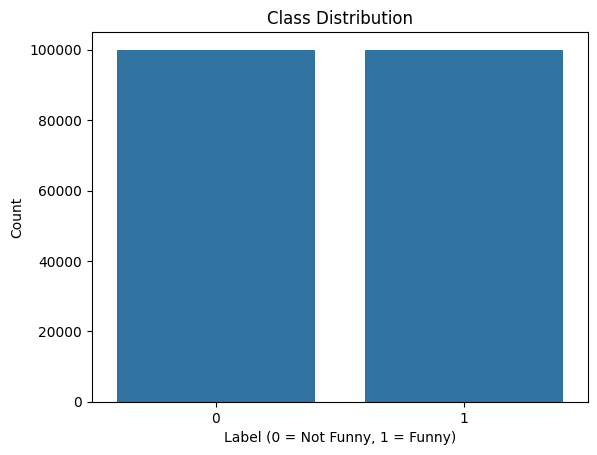

In [20]:
# Checking the distribution of funny and not funny sentences
sns.countplot(x='is_funny', data=df)
plt.title("Class Distribution")
plt.xlabel("Label (0 = Not Funny, 1 = Funny)")
plt.ylabel("Count")
plt.show()

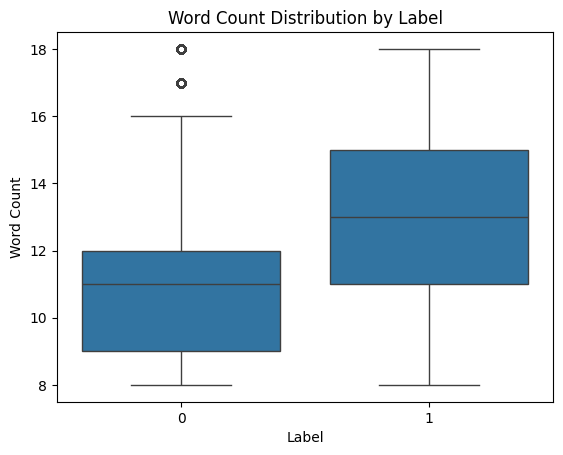

In [21]:
# distributions for word count of a single sentence for the funny and unfunny sentences
df['word_count'] = df['text'].apply(lambda x: len(x.split()))

sns.boxplot(data=df, x='is_funny', y='word_count')
plt.title("Word Count Distribution by Label")
plt.xlabel("Label")
plt.ylabel("Word Count")
plt.show()

## Findings

I have found that there are the same number of funny and unfunny sentences in the dataset. I have also found that, on average, senteces that are considered funny, also have more words in them.

# Training and Evaluation

In [22]:
# number of unique words that will be stored in our embeddings
VOCAB_SIZE = 5000
# convert each joke into list of integers using one hot encoding. Each word
# is mapped to a unique integer, between [1, VOCAB_SIZE].
encoded_jokes = [one_hot(d, VOCAB_SIZE) for d in df['text'] ]
# ensures that all encoded sequences have the same length
padded_jokes = pad_sequences(encoded_jokes, padding='post')

In [23]:
print(padded_jokes)

[[ 480  464  623 ...    0    0    0]
 [3832 2771 2273 ...    0    0    0]
 [ 203 1463 1113 ...    0    0    0]
 ...
 [3822 3447 3327 ...    0    0    0]
 [4296 2338 4956 ...    0    0    0]
 [ 794  548 3869 ...    0    0    0]]


In [24]:
# feedforward neural network
# each input sentence is passed through an embedding layer, flattened, and then
# fed through two fully connected layers with ReLU activation, followed by a sigmoid
# output neuron to predict probability of being funny.
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=32))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

# prepares model for training
# the cost function we will use is binary crossentropy using Adam optimizer for gradient descent
# I shouldn't normalize my inputs, because my input layer is an embedding layer. Therefore, each joke
# is represented as a list of integers, where each integer is a word index. Therefore, normalizing the data
# would hurt the model's accuracy, as it would associate the wrong words to the wrong indices.
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# train test split
X_train, X_test, y_train, y_test = train_test_split(padded_jokes, df['is_funny'], test_size=0.2, random_state=42)

# does the split for validation, and fits the model with the data
# here is the part where the forward and backward propagation occurs
model.fit(x=X_train, y=y_train, validation_split=0.2, epochs= 3, batch_size=32)

Epoch 1/3
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 26s 6ms/step - accuracy: 0.9018 - loss: 0.2405 - val_accuracy: 0.9377 - val_loss: 0.1621
Epoch 2/3
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 26s 6ms/step - accuracy: 0.9521 - loss: 0.1271 - val_accuracy: 0.9378 - val_loss: 0.1628
Epoch 3/3
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 25s 6ms/step - accuracy: 0.9688 - loss: 0.0795 - val_accuracy: 0.9322 - val_loss: 0.1964


In [25]:
# presenting the results (loss, accuracy)
model.evaluate(X_test, y_test)

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9279 - loss: 0.2135


[0.2041085809469223, 0.9292749762535095]

## Task 3
In task 2 describe how you selected the hyperparameters. What was the
rationale behind the technique you used? Did you use regularization? Why, or why not? Did you use
an optimization algorithm? Why or why not?

*   I chose a vocab size of 5000, as it is large enough to capture common words, while also being a manageable size.
*   I chose to have the embedding dimension equal to 32, as this is standard
*   I also chose the dense layer sizes, as these are the standards.
*   I chose to epoch size of 3, as I found that it trained the model realtively quickly, whlie also having a high accuracy
*   I chose a batch size of 32, as this is a common value used.

I did use a regulatization techinque (Dropout), as it helps prevent the model from overfitting. I chose dropout rate equal to 0.2, as this is a common value used.

I used the Adam optimizer, because of the fact that it automatically adjusts learning rates. It also converges faster than regular gradient descent, resulting in a faster compute time.





